# Transfer learning for NLP
## ALTEGRAD - Lab session 3
#### Moussa Kamal Eddine, Hadi Abdine (Dascim LIX)
##### 23 November 2021

In [2]:
import math

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### The Model

In [3]:
class TransformerModel(nn.Module):
    def __init__(self, ntoken, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        '''
        ntokens: the size of vocabulary
        nhid: the hidden dimension of the model.
        We assume that embedding_dim = nhid
        nlayers: the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
        nhead: the number of heads in the multiheadattention models
        dropout: the dropout value
         '''
        self.model_type = "Transformer"
        self.encoder = nn.Embedding(ntoken, nhid) # fill me, nhid = the dim_embed
        self.pos_encoder = PositionalEncoding(nhid, dropout) #fill me, the PositionalEncoding class is implemented in the next cell
        encoder_layers = nn.TransformerEncoderLayer(nhid, nhead, nhid, dropout) #fill me we assume nhid = d_model = dim_feedforward
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers) #fill me
        self.nhid = nhid
        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = (
            mask.float()
            .masked_fill(mask == 0, float("-inf"))
            .masked_fill(mask == 1, float(0.0))
        )
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src = self.encoder(src) * math.sqrt(self.nhid) 
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        return output


class ClassificationHead(nn.Module):
    def __init__(self, nhid, nclasses):
        super(ClassificationHead, self).__init__()
        self.decoder = nn.Linear(nhid, nclasses) #fill me
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        output = self.decoder(src)
        return output
    
class Model(nn.Module):
    def __init__(self, ntoken, nhead, nhid, nlayers, nclasses, dropout=0.5):
        super(Model, self).__init__()
        self.base = TransformerModel(ntoken, nhead, nhid, nlayers, dropout) #fill me
        self.classifier = ClassificationHead(nhid, nclasses) #fill me 

    def forward(self, src, src_mask):
        # base model
        x = self.base(src,src_mask) #fill me
        # classifier model
        output = self.classifier(x) #fill me
        return output

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, nhid, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, nhid)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, nhid, 2).float() * (-math.log(10000.0) / nhid)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0), :]
        return self.dropout(x)

Let's verify if our model works, by applying one inference step

In [5]:
ntokens = 100 # the size of vocabulary
nhid = 200  # hidden dimension
nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0  # the dropout value

model = Model(ntokens, nhead, nhid, nlayers, ntokens, dropout).to(device)
dummy_input = torch.tensor([[2, 6, 2, 5, 43, 21]]).to(device)
src_mask = model.base.generate_square_subsequent_mask(1).to(device)
out = model.forward(dummy_input, src_mask)

print(out.shape) # is it the right shape? -> yep

torch.Size([1, 6, 100])


## Vocabulary and Tokenization

In [6]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/dict.txt
!head -5 dict.txt

--2021-11-30 19:15:22--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/dict.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 577587 (564K) [text/plain]
Saving to: ‘dict.txt’

dict.txt            100%[===================>] 564.05K  --.-KB/s    in 0.04s   

2021-11-30 19:15:23 (13.3 MB/s) - ‘dict.txt’ saved [577587/577587]

▁d 1
es 1
▁l 1
en 1
on 1


In [7]:
path_vocab = "dict.txt"
token2ind = {"<sos>": 0, "<pad>": 1, "<eos>": 2, "<oov>": 3} # the 4 first indices are reserved to special tokens
with open(path_vocab, "r") as f:
    for idx, line in enumerate(f):
        word = line.split()[0].strip()
        token2ind[word] = idx + 4 #fill me

ind2token =  dict(zip(token2ind.values(), token2ind.keys())) #fill me

print(ind2token[1111])

▁trop


### Data Loader


In [8]:
import numpy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset


class Dataset(Dataset):
    def __init__(
        self,
        path_documents,
        path_labels=None,
        token2ind={},
        max_len=512,
        task="language_modeling",
    ):
        self.task = task
        self.max_len = max_len
        self.token2ind = token2ind
        self.documents = []
        self.labels = []
        with open(path_documents, "r") as f1:
            for line in f1:
                self.documents.append(line.strip())
        if task == "classification":
            with open(path_labels, "r") as f1:
                for line in f1:
                    self.labels.append(int(line.strip()))
            assert len(self.labels) == len(self.documents)

    def __len__(self):
        return len(self.documents)

    def __getitem__(self, index):
        sequence = self.documents[index].split()
        if len(sequence) > self.max_len - 1:
            sequence = sequence[: self.max_len - 1]
        source_sequence = [self.token2ind["<sos>"]]
        for word in sequence[:self.max_len]:
          if word in self.token2ind:
            source_sequence.append(self.token2ind[word])
          else:
            source_sequence.append(self.token2ind["<oov>"])

        if self.task == "language_modeling":
            target = source_sequence[1:]
            target.append(self.token2ind["<eos>"])
        elif self.task == "classification":
            target = [self.labels[index]]
        sample = {
            "source_sequence": torch.tensor(source_sequence),
            "target": torch.tensor(target),
        }
        return sample


def MyCollator(batch):
    source_sequences = pad_sequence(
        #we use padding to match the length of the sequences in the same batch
        [sample["source_sequence"] for sample in batch], padding_value=token2ind["<pad>"]
    )
    target = pad_sequence(
        [sample["target"] for sample in batch], padding_value=token2ind["<pad>"]
    )
    return source_sequences, target.reshape(-1)


def get_loader(
    path_documents,
    path_labels=None,
    token2ind={},
    max_len=512,
    batch_size=32,
    task="language_modeling",
):
    dataset = Dataset(
        path_documents,
        path_labels=path_labels,
        token2ind=token2ind,
        max_len=512,
        task=task,
    )
    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=MyCollator,
        pin_memory=True,
        drop_last=True,
    )
    return data_loader

## The Training

In [9]:
def train(
    path_data_train,
    path_labels_train=None,
    path_data_valid=None,
    save_interval=-1,
    log_interval=5,
    task="language_modeling",
    batch_size=32,
):
    model.train()
    total_loss = 0.0
    ntokens = len(token2ind)
    data_loader = get_loader(
        path_data_train,
        path_labels_train,
        token2ind,
        task=task,
        batch_size=batch_size,
    )
    
    losses = []
    for idx, data in enumerate(data_loader): #step 1
        optimizer.zero_grad()
        src_mask = model.base.generate_square_subsequent_mask(data[0].size(0)).to(
            device
        )
        input = data[0].to(device)
        output = model(input, src_mask) #step 2
        if task == 'classification':
            #last vector only
            output = output[-1] #fill me 
        output = output.view(-1, output.shape[-1])
        target = data[1] #fill me
        target = target.to(device)
        loss = criterion(output,target) #fill me, Cross entropy check next cells
        #fill me step 3
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) # prevent exploding gradient 
        #fill me step 4
        optimizer.step()

        total_loss += loss.item() 
        if idx % log_interval == 0 and idx > 0:
            cur_loss = total_loss / log_interval
            print(
                "| epoch {:3d} | {:5d}/{:5d} steps | "
                "loss {:5.5f} | ppl {:8.3f}".format(
                    epoch, idx, len(data_loader), cur_loss, math.exp(cur_loss),
                )
            )
            losses.append(cur_loss)
            total_loss = 0
    return losses

In [10]:
ntokens = len(ind2token)#fill me # the size of vocabulary
nhid = 200  # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0  # the dropout value

nclasses = 2 # for classification task only

model = Model(ntokens, nhead, nhid, nlayers, ntokens, dropout).to(device)

In [27]:
def count_parameter(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [30]:
p = count_parameter(model)
p2 = p - (10000200+50001) + 200*2+2
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.numel())
print("Final number of parameters for language model: ", p)
print("Final number of parameters for classification model:", p2)

base.encoder.weight 10000200
base.transformer_encoder.layers.0.self_attn.in_proj_weight 120000
base.transformer_encoder.layers.0.self_attn.in_proj_bias 600
base.transformer_encoder.layers.0.self_attn.out_proj.weight 40000
base.transformer_encoder.layers.0.self_attn.out_proj.bias 200
base.transformer_encoder.layers.0.linear1.weight 40000
base.transformer_encoder.layers.0.linear1.bias 200
base.transformer_encoder.layers.0.linear2.weight 40000
base.transformer_encoder.layers.0.linear2.bias 200
base.transformer_encoder.layers.0.norm1.weight 200
base.transformer_encoder.layers.0.norm1.bias 200
base.transformer_encoder.layers.0.norm2.weight 200
base.transformer_encoder.layers.0.norm2.bias 200
base.transformer_encoder.layers.1.self_attn.in_proj_weight 120000
base.transformer_encoder.layers.1.self_attn.in_proj_bias 600
base.transformer_encoder.layers.1.self_attn.out_proj.weight 40000
base.transformer_encoder.layers.1.self_attn.out_proj.bias 200
base.transformer_encoder.layers.1.linear1.weight 

In [11]:
# optimization paramerters

criterion = nn.CrossEntropyLoss(ignore_index=token2ind['<pad>'])
lr = 0.0003  # learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [11]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretraining_subset.txt
path_data_train = "pretraining_subset.txt"

--2021-11-28 21:05:18--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretraining_subset.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10146460 (9.7M) [text/plain]
Saving to: ‘pretraining_subset.txt.1’

pretraining_subset. 100%[===================>]   9.68M  --.-KB/s    in 0.1s    

2021-11-28 21:05:18 (82.8 MB/s) - ‘pretraining_subset.txt.1’ saved [10146460/10146460]



In [12]:
#pretraining on a tiny subset
log_interval = 500
epochs = 2
for epoch in range(1, epochs + 1): #5
    train(
        path_data_train,
        save_interval=-1,
        task='language_modeling', # fill me
        batch_size=16,
        log_interval=log_interval,
    )

| epoch   1 |   500/ 3125 steps | loss 7.35122 | ppl 1558.104
| epoch   1 |  1000/ 3125 steps | loss 6.49794 | ppl  663.772
| epoch   1 |  1500/ 3125 steps | loss 6.21627 | ppl  500.830
| epoch   1 |  2000/ 3125 steps | loss 6.02980 | ppl  415.632
| epoch   1 |  2500/ 3125 steps | loss 5.92866 | ppl  375.652
| epoch   1 |  3000/ 3125 steps | loss 5.86064 | ppl  350.949
| epoch   2 |   500/ 3125 steps | loss 5.54248 | ppl  255.310
| epoch   2 |  1000/ 3125 steps | loss 5.47064 | ppl  237.612
| epoch   2 |  1500/ 3125 steps | loss 5.45993 | ppl  235.081
| epoch   2 |  2000/ 3125 steps | loss 5.42337 | ppl  226.642
| epoch   2 |  2500/ 3125 steps | loss 5.39457 | ppl  220.207
| epoch   2 |  3000/ 3125 steps | loss 5.39280 | ppl  219.817


## Text Generation


In [13]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretrained_model_4layers.pt

model = Model(ntokens, nhead, nhid, nlayers, ntokens).to(device) 

#load the checkpoint
checkpoint = torch.load('pretrained_model_4layers.pt') 
#load state dict
model.load_state_dict(checkpoint['model_state_dict']) 

--2021-11-28 21:16:42--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretrained_model_4layers.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88093955 (84M) [application/octet-stream]
Saving to: ‘pretrained_model_4layers.pt.1’

pretrained_model_4l 100%[===================>]  84.01M   169MB/s    in 0.5s    

2021-11-28 21:16:42 (169 MB/s) - ‘pretrained_model_4layers.pt.1’ saved [88093955/88093955]



<All keys matched successfully>

In [14]:
!pip install sentencepiece
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/sentencepiece.french.model

import sentencepiece as spm

s = spm.SentencePieceProcessor(model_file='sentencepiece.french.model') #load sentencepiece model

#examples
encoded = s.encode_as_pieces("Bonjour les amis!")
decoded = s.decode_pieces(encoded)
print(encoded)
print(decoded)

--2021-11-28 21:16:46--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/sentencepiece.french.model
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115362 (1.1M) [application/octet-stream]
Saving to: ‘sentencepiece.french.model.1’

sentencepiece.frenc 100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2021-11-28 21:16:46 (16.7 MB/s) - ‘sentencepiece.french.model.1’ saved [1115362/1115362]

['▁Bonjour', '▁les', '▁amis', '!']
Bonjour les amis!


In [15]:
def infer_next_token(sent):
    model.eval()
    sent_pieces = s.encode_as_pieces(sent)
    source = [token2ind['<sos>']] + [token2ind[el] for el in sent_pieces] # list of tokens
    source = torch.tensor(source).to(device)
    source = source.reshape(-1, 1)
    src_mask = model.base.generate_square_subsequent_mask(source.size(0)).to(device)
    out = model(source, src_mask)
    next_token_ind = out[-1].argmax(-1) #fill me
    return next_token_ind, out
    
def infer_next_tokens(sent, max_len=50):
    # to be implemented
    i=0
    newsent = sent
    while i <= max_len:
      next_token_ind, out = infer_next_token(newsent)
      next_word = ind2token[next_token_ind.squeeze().item()]
      newsent += next_word
      if next_word == '<eos>': break
    return newsent

In [16]:
sent = "Bonjour les"
newsent = infer_next_tokens(sent)
print(newsent)

Bonjour les▁gens▁qui▁ont▁été▁très▁accueillants▁et▁sympathiques.<eos>


### Supervised task

In [17]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.review.spm
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.label
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/test.review.spm
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/test.label

path_data_train = "train.review.spm"
path_labels_train = "train.label"

path_data_valid = "test.review.spm"
path_labels_valid = "test.label"

--2021-11-28 21:16:46--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.review.spm
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1495960 (1.4M) [text/plain]
Saving to: ‘train.review.spm.2’

train.review.spm.2  100%[===================>]   1.43M  --.-KB/s    in 0.07s   

2021-11-28 21:16:46 (21.6 MB/s) - ‘train.review.spm.2’ saved [1495960/1495960]

--2021-11-28 21:16:47--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.label
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request s

In [18]:
# a function to evaluate the validation accuracy of the model.
from tqdm import tqdm
def evaluate_accuracy(data_loader):
    #to be implemented
    true_ , total = 0,0
    for (source, target) in tqdm(iter(data_loader), leave=False):
      source, target = source.to(device), target.to(device)
      src_mask = model.base.generate_square_subsequent_mask(source.size(0)).to(device)
      output = model(source, src_mask)
      _,predict = torch.max(output.data[-1],1)
      true_ += (predict == target).sum()
      total += target.size(0)
    print(f"Validation accuracy: {(true_/total).item()}")
    return (true_/total).item()



In [19]:
# test
#dataloader = get_loader(
#                path_data_valid,
#                path_labels_valid,
#                token2ind=token2ind,
#                batch_size=20,
#                task='classification',
#            )
#i = evaluate_accuracy(dataloader)

In [20]:
#save the base model to be loaded later in the fine-tuning phase
torch.save({"model_state_dict": model.base.state_dict(),}, "pretrained_model_4layers_no_class_head.pt")

In [21]:
from_scratch_settings = [True, False]

from_scratch_valid_acc = []
pretrained_valid_acc = []
lr = 0.0001

for from_scratch in from_scratch_settings:
    model = Model(ntokens, nhead, nhid, nlayers, 2, dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    if not from_scratch:
        print("=====PRETRAINED MODEL======")
        #load checkpoint
        checkpoint = torch.load("pretrained_model_4layers_no_class_head.pt")
        #load state dict
        model.base.load_state_dict(checkpoint['model_state_dict'])
    else:
        print("=====Trainig FROM SCRATCH======")
    epochs = 15
    for epoch in range(1, epochs + 1):
        train(
            path_data_train,
            path_labels_train,
            save_interval=-1,
            task='classification',
            batch_size=8,
            log_interval=50,
        )
        acc = evaluate_accuracy(
            get_loader(
                path_data_valid,
                path_labels_valid,
                token2ind=token2ind,
                batch_size=20,
                task='classification',
            )
        )
        if from_scratch:
            from_scratch_valid_acc.append(acc)
        else:
            pretrained_valid_acc.append(acc)
    print()

=====Trainig FROM SCRATCH======
| epoch   1 |    50/  200 steps | loss 0.77527 | ppl    2.171
| epoch   1 |   100/  200 steps | loss 0.75971 | ppl    2.138
| epoch   1 |   150/  200 steps | loss 0.73607 | ppl    2.088


Validation accuracy: 0.5075000524520874
| epoch   2 |    50/  200 steps | loss 0.68499 | ppl    1.984
| epoch   2 |   100/  200 steps | loss 0.60899 | ppl    1.839
| epoch   2 |   150/  200 steps | loss 0.62221 | ppl    1.863


Validation accuracy: 0.7080000042915344
| epoch   3 |    50/  200 steps | loss 0.39901 | ppl    1.490
| epoch   3 |   100/  200 steps | loss 0.47744 | ppl    1.612
| epoch   3 |   150/  200 steps | loss 0.38451 | ppl    1.469


Validation accuracy: 0.7665000557899475
| epoch   4 |    50/  200 steps | loss 0.21433 | ppl    1.239
| epoch   4 |   100/  200 steps | loss 0.22317 | ppl    1.250
| epoch   4 |   150/  200 steps | loss 0.22002 | ppl    1.246


Validation accuracy: 0.7615000605583191
| epoch   5 |    50/  200 steps | loss 0.01949 | ppl    1.020
| epoch   5 |   100/  200 steps | loss 0.11221 | ppl    1.119
| epoch   5 |   150/  200 steps | loss 0.04526 | ppl    1.046


Validation accuracy: 0.7130000591278076
| epoch   6 |    50/  200 steps | loss 0.03662 | ppl    1.037
| epoch   6 |   100/  200 steps | loss 0.00031 | ppl    1.000
| epoch   6 |   150/  200 steps | loss 0.00014 | ppl    1.000


Validation accuracy: 0.7310000061988831
| epoch   7 |    50/  200 steps | loss 0.00004 | ppl    1.000
| epoch   7 |   100/  200 steps | loss 0.00368 | ppl    1.004
| epoch   7 |   150/  200 steps | loss 0.00003 | ppl    1.000


Validation accuracy: 0.7410000562667847
| epoch   8 |    50/  200 steps | loss 0.00002 | ppl    1.000
| epoch   8 |   100/  200 steps | loss 0.00002 | ppl    1.000
| epoch   8 |   150/  200 steps | loss 0.00002 | ppl    1.000


Validation accuracy: 0.7460000514984131
| epoch   9 |    50/  200 steps | loss 0.00002 | ppl    1.000
| epoch   9 |   100/  200 steps | loss 0.00002 | ppl    1.000
| epoch   9 |   150/  200 steps | loss 0.00002 | ppl    1.000


Validation accuracy: 0.749500036239624
| epoch  10 |    50/  200 steps | loss 0.00001 | ppl    1.000
| epoch  10 |   100/  200 steps | loss 0.00001 | ppl    1.000
| epoch  10 |   150/  200 steps | loss 0.00001 | ppl    1.000


Validation accuracy: 0.7465000152587891
| epoch  11 |    50/  200 steps | loss 0.00001 | ppl    1.000
| epoch  11 |   100/  200 steps | loss 0.00001 | ppl    1.000
| epoch  11 |   150/  200 steps | loss 0.00001 | ppl    1.000


Validation accuracy: 0.7465000152587891
| epoch  12 |    50/  200 steps | loss 0.00001 | ppl    1.000
| epoch  12 |   100/  200 steps | loss 0.00001 | ppl    1.000
| epoch  12 |   150/  200 steps | loss 0.00001 | ppl    1.000


Validation accuracy: 0.7515000104904175
| epoch  13 |    50/  200 steps | loss 0.00001 | ppl    1.000
| epoch  13 |   100/  200 steps | loss 0.00001 | ppl    1.000
| epoch  13 |   150/  200 steps | loss 0.00001 | ppl    1.000


Validation accuracy: 0.7450000643730164
| epoch  14 |    50/  200 steps | loss 0.00001 | ppl    1.000
| epoch  14 |   100/  200 steps | loss 0.00001 | ppl    1.000
| epoch  14 |   150/  200 steps | loss 0.00001 | ppl    1.000


Validation accuracy: 0.7505000233650208
| epoch  15 |    50/  200 steps | loss 0.00000 | ppl    1.000
| epoch  15 |   100/  200 steps | loss 0.00024 | ppl    1.000
| epoch  15 |   150/  200 steps | loss 0.00000 | ppl    1.000


Validation accuracy: 0.7555000185966492

=====PRETRAINED MODEL======
| epoch   1 |    50/  200 steps | loss 0.82072 | ppl    2.272
| epoch   1 |   100/  200 steps | loss 0.68930 | ppl    1.992
| epoch   1 |   150/  200 steps | loss 0.57291 | ppl    1.773


Validation accuracy: 0.7480000257492065
| epoch   2 |    50/  200 steps | loss 0.55091 | ppl    1.735
| epoch   2 |   100/  200 steps | loss 0.48298 | ppl    1.621
| epoch   2 |   150/  200 steps | loss 0.45700 | ppl    1.579


Validation accuracy: 0.7415000200271606
| epoch   3 |    50/  200 steps | loss 0.39994 | ppl    1.492
| epoch   3 |   100/  200 steps | loss 0.40129 | ppl    1.494
| epoch   3 |   150/  200 steps | loss 0.32743 | ppl    1.387


Validation accuracy: 0.796500027179718
| epoch   4 |    50/  200 steps | loss 0.25457 | ppl    1.290
| epoch   4 |   100/  200 steps | loss 0.26915 | ppl    1.309
| epoch   4 |   150/  200 steps | loss 0.25467 | ppl    1.290


Validation accuracy: 0.7925000190734863
| epoch   5 |    50/  200 steps | loss 0.18992 | ppl    1.209
| epoch   5 |   100/  200 steps | loss 0.24540 | ppl    1.278
| epoch   5 |   150/  200 steps | loss 0.24774 | ppl    1.281


Validation accuracy: 0.7640000581741333
| epoch   6 |    50/  200 steps | loss 0.13714 | ppl    1.147
| epoch   6 |   100/  200 steps | loss 0.15936 | ppl    1.173
| epoch   6 |   150/  200 steps | loss 0.14893 | ppl    1.161


Validation accuracy: 0.7825000286102295
| epoch   7 |    50/  200 steps | loss 0.07038 | ppl    1.073
| epoch   7 |   100/  200 steps | loss 0.09136 | ppl    1.096
| epoch   7 |   150/  200 steps | loss 0.09362 | ppl    1.098


Validation accuracy: 0.7905000448226929
| epoch   8 |    50/  200 steps | loss 0.02090 | ppl    1.021
| epoch   8 |   100/  200 steps | loss 0.01795 | ppl    1.018
| epoch   8 |   150/  200 steps | loss 0.04926 | ppl    1.050


Validation accuracy: 0.7915000319480896
| epoch   9 |    50/  200 steps | loss 0.00119 | ppl    1.001
| epoch   9 |   100/  200 steps | loss 0.03494 | ppl    1.036
| epoch   9 |   150/  200 steps | loss 0.05066 | ppl    1.052


Validation accuracy: 0.7940000295639038
| epoch  10 |    50/  200 steps | loss 0.01183 | ppl    1.012
| epoch  10 |   100/  200 steps | loss 0.00020 | ppl    1.000
| epoch  10 |   150/  200 steps | loss 0.00129 | ppl    1.001


Validation accuracy: 0.8015000224113464
| epoch  11 |    50/  200 steps | loss 0.00001 | ppl    1.000
| epoch  11 |   100/  200 steps | loss 0.00118 | ppl    1.001
| epoch  11 |   150/  200 steps | loss 0.00003 | ppl    1.000


Validation accuracy: 0.7870000600814819
| epoch  12 |    50/  200 steps | loss 0.00010 | ppl    1.000
| epoch  12 |   100/  200 steps | loss 0.00006 | ppl    1.000
| epoch  12 |   150/  200 steps | loss 0.00008 | ppl    1.000


Validation accuracy: 0.796500027179718
| epoch  13 |    50/  200 steps | loss 0.00004 | ppl    1.000
| epoch  13 |   100/  200 steps | loss 0.00353 | ppl    1.004
| epoch  13 |   150/  200 steps | loss 0.00233 | ppl    1.002


Validation accuracy: 0.7860000133514404
| epoch  14 |    50/  200 steps | loss 0.00014 | ppl    1.000
| epoch  14 |   100/  200 steps | loss 0.00000 | ppl    1.000
| epoch  14 |   150/  200 steps | loss 0.03623 | ppl    1.037


Validation accuracy: 0.7925000190734863
| epoch  15 |    50/  200 steps | loss 0.00030 | ppl    1.000
| epoch  15 |   100/  200 steps | loss 0.00104 | ppl    1.001
| epoch  15 |   150/  200 steps | loss 0.00031 | ppl    1.000


Validation accuracy: 0.7925000190734863



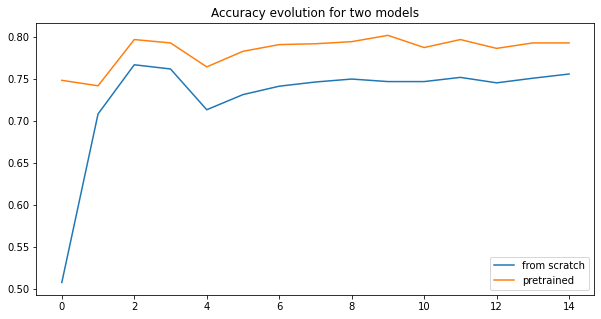

In [22]:
#Visualize the accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(from_scratch_valid_acc,label="from scratch")
plt.plot(pretrained_valid_acc,label='pretrained')
plt.legend()
plt.title("Accuracy evolution for two models")
plt.show()